<a href="https://colab.research.google.com/github/tonyhathuc/project-week-9-final-project/blob/master/final_project9_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

##### stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

##### train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

##### test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

##### features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index (The Consumer Price Index measures the average change in prices over time that consumers pay for a basket of goods and services.)
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

# Import libraries and load data

In [ ]:
pip install chart_studio

In [ ]:
# import libraries

import numpy as np 
import pandas as pd 

# data viz libraries
import seaborn as sns
sns.set(style="whitegrid") # to make charts look better
import matplotlib.pyplot as plt
%matplotlib inline

# for functions
from tqdm import tqdm

# for ML
import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# import plotly modules
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff

# make it work on jupyter notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Use Plotly locally
cf.go_offline()

In [ ]:
# load datasets

dataFeatures = pd.read_csv("https://raw.githubusercontent.com/tonyhathuc/project-week-9-final-project/master/data/features.csv")
dataStores = pd.read_csv("https://raw.githubusercontent.com/tonyhathuc/project-week-9-final-project/master/data/stores.csv")
dataTest = pd.read_csv("https://raw.githubusercontent.com/tonyhathuc/project-week-9-final-project/master/data/test.csv")
dataTrain = pd.read_csv("https://raw.githubusercontent.com/tonyhathuc/project-week-9-final-project/master/data/train.csv")


# EDA and Data Cleaning

- Here we will explore the data in order to search for patterns relationships and to understand them better. 
- Perform data cleaning if neccessary and data wrangling.
   

In [ ]:
dataStores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
dataStores.shape 

(45, 3)

In [ ]:
dataFeatures.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [ ]:
dataFeatures.shape

(8190, 12)

In [ ]:
# we will start by merging dataStores and dataFeatures since Features is the extension of Stores
FeatSto = dataFeatures.merge(dataStores, how="inner", on="Store")

# check the head of the new df
FeatSto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [ ]:
FeatSto.shape

(8190, 14)

In [ ]:
# check the dtypes in FeatSto

FeatSto.dtypes

# Type is of categorical nature
# IsHoliday of binary categorical nature 

# the rest are numerical
# some of the features might contain numerical values but still behave as categorical
# Date is string and we will convert it into datetime later or drop it

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

In [ ]:
# check for missing values
FeatSto.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
Type               0
Size               0
dtype: int64

## Inspect the train and test data (dataTrain and dataTest)

In [ ]:
dataTest.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
dataTest.shape

(115064, 4)

In [ ]:
# as we can see  dataTrain includes additional Weekly_Sales
dataTrain.tail(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [ ]:
dataTrain.shape

(421570, 5)

In [ ]:
dataTest.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [ ]:
dataTrain.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [ ]:
# we will disregard the dataTest and use only dataTrain
# (we will train-test split the data later)
# merge dataTrain with Featsto ->dfwTrain
# now we have a dataframe containing dataTrain
# FeatSto with dataTrain

dfwTrain = pd.merge(FeatSto, dataTrain, how="inner", on=["Store", "Date", "IsHoliday"])

dfwTrain.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38


In [ ]:
dfwTrain.shape

(421570, 16)

In [ ]:
dfwTrain.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48
421569,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,98,1076.80


In [ ]:
# rename dfwTrain into df_total

df_total = dfwTrain

# show the head of the total dataframe

df_total.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38


In [ ]:
# show the tail

df_total.tail()

# first impression:
# Date is the week
# Markdowns 1 - 5 contain a lot of missing values
# Weekly_Sales is numerical continuous data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48
421569,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,98,1076.80


In [ ]:
# check the shape of df_total

df_total.shape

(421570, 16)

In [ ]:
# check the dtypes of df_total

df_total.dtypes

# most features have numerical values
# Date, Type is a string
# some features with numerical values might behave as categoricals, encode them later
# such as Type, IsHoliday

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
Dept              int64
Weekly_Sales    float64
dtype: object

In [ ]:
# now we can check for missing values

df_total.isnull().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales         0
dtype: int64

In [ ]:
# calculate the percentage of missing values in each column

df_total.isnull().sum() / len(df_total)

# if the column contains 85% missing values then it should be dropped
# MarkDown1-5 contains anonymized data and lots of missing values, despite that they contain important data

Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
IsHoliday       0.000000
Type            0.000000
Size            0.000000
Dept            0.000000
Weekly_Sales    0.000000
dtype: float64

In [ ]:
# instead of dropping, we will fill the NaN values with zero values
# because the code was executed the first time, when we execute it again, it will show an error
df_total.fillna(0, inplace=True)

df_total.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,5,32229.38


In [ ]:
# check for missing values again

df_total.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
Dept            0
Weekly_Sales    0
dtype: int64

In [ ]:
# check for duplicated values

df_total.duplicated().sum()

# no duplicates

0

In [ ]:
# add a Month column

df_total["Month"] = pd.to_datetime(df_total['Date']).dt.month
df_total.sample(5) 

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month
353186,37,2012-08-17,85.89,3.571,170.08,0.0,13.16,0.00,792.21,220.719961,6.623,False,C,39910,92,59876.55,8
410659,44,2012-05-11,56.47,3.809,529.20,0.0,2.10,0.00,1064.56,131.145333,5.621,False,C,39910,92,44258.85,5
67290,7,2012-06-01,55.06,3.764,2427.12,0.0,98.67,1349.72,2112.74,197.621895,8.090,False,B,70713,42,6610.07,6
51613,6,2010-11-05,59.90,2.689,0.00,0.0,0.00,0.00,0.00,213.478550,7.007,False,A,202505,67,8997.97,11
250834,26,2011-03-11,28.13,3.600,0.00,0.0,0.00,0.00,0.00,133.736143,7.907,False,A,152513,42,1646.35,3


In [ ]:
## add a Week column 
df_total["Week"] = pd.to_datetime(df_total["Date"]).dt.week
df_total.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month,Week
187874,20,2010-03-26,50.49,2.854,0.00,0.00,0.0,0.00,0.00,204.201755,8.187,False,A,203742,37,3840.57,3,12
155373,16,2012-03-30,48.29,3.750,3404.77,0.00,5.0,188.80,1133.72,197.413326,6.162,False,B,57197,33,3059.55,3,13
172978,18,2011-09-02,68.23,3.784,0.00,0.00,0.0,0.00,0.00,136.244097,8.890,False,B,120653,31,3515.77,9,35
370581,39,2012-09-21,73.58,3.721,11644.30,112.91,6.7,3300.92,13244.99,221.457860,6.623,False,A,184109,44,5218.16,9,38
117890,13,2010-02-26,29.98,2.667,0.00,0.00,0.0,0.00,0.00,126.552286,8.316,False,A,219622,79,54476.12,2,8


In [ ]:
# add Year column
df_total["Year"] = pd.to_datetime(df_total["Date"]).dt.year 
df_total.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month,Week,Year
201409,21,2011-03-11,54.69,3.459,0.00,0.00,0.0,0.0,0.00,213.764640,8.028,False,B,140167,56,1668.68,3,10,2011
319217,33,2012-04-13,73.17,4.254,492.15,335.84,0.0,0.0,1369.05,131.108000,7.396,False,A,39690,81,10814.79,4,15,2012
159945,17,2010-10-15,47.35,2.845,0.00,0.00,0.0,0.0,0.00,126.326677,6.885,False,B,93188,30,2006.10,10,41,2010
352576,37,2012-06-01,80.74,3.501,57.81,0.00,0.0,0.0,1268.73,220.432210,6.989,False,C,39910,13,17369.54,6,22,2012
314796,33,2010-06-11,93.52,3.057,0.00,0.00,0.0,0.0,0.00,126.111903,9.849,False,A,39690,8,2863.63,6,23,2010


In [ ]:
# convert "Date" column to datetime format
df_total["Date"] = pd.to_datetime(df_total["Date"])
df_total.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Type                    object
Size                     int64
Dept                     int64
Weekly_Sales           float64
Month                    int64
Week                     int64
Year                     int64
dtype: object

In [ ]:
df_total.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month,Week,Year
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,1,24924.50,2,5,2010
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,2,50605.27,2,5,2010
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,3,13740.12,2,5,2010
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,4,39954.04,2,5,2010
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,5,32229.38,2,5,2010


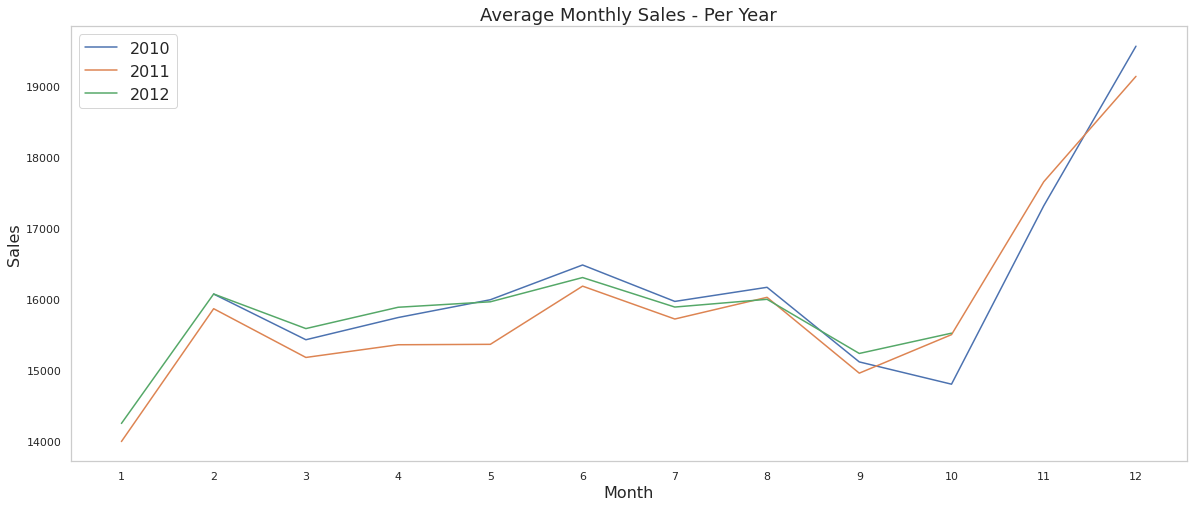

In [ ]:
# plot Average Monthly Sales - Per Year

weekly_sales_2010 = df_total[df_total.Year==2010]['Weekly_Sales'].groupby(df_total['Month']).mean()
weekly_sales_2011 = df_total[df_total.Year==2011]['Weekly_Sales'].groupby(df_total['Month']).mean()
weekly_sales_2012 = df_total[df_total.Year==2012]['Weekly_Sales'].groupby(df_total['Month']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 13, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Monthly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.show()

# 2012 compared to the rest was not doing so well

# there is a sharp rise in Sales between January and February, which is connected to SuperBowl
# and as we can see, the Monthly Sales are usually spiking in November and December
# when Thanksgiving and Christmas are happening



In [ ]:
# use Plotly to plot TimeSeries to see whether Date affects Weekly_Sales
# make one plot

px.line(df_total, x="Date", y="Weekly_Sales", labels={"x":"Date", "y":"Weekly_Sales"},
       title="Weekly Sales across Feb 2010 - Oct 2012")

# in more detail, we can see how Date affects Weekly Sales
# the highest spikes are on Thanksgiving Day and Christmas Day
# as we have seen in the previous plot, 2012 was not so good in terms of sales for Walmart

In [ ]:
# now we can drop Date column now

df_total.drop(["Date"], inplace=True, axis=1)
df_total.sample(5)

For Linear Regression, we need to have numerical values. Thus we will encode the categorical features from the dataset into numerical values.

Since it's of categorical text data. We use Label Encoder to convert them into model-understandable numerical data.

In [ ]:
# encode Type

from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
df_total['Type']= le.fit_transform(df_total['Type'])

In [ ]:
# encode IsHoliday

df_total['IsHoliday'] = le.fit_transform(df_total['IsHoliday'])

In [ ]:
df_total.shape

In [ ]:
# took a sample with the size of 5000, which should be enough to better understand the relationship between the columns

# had problems with loading the plot, that's why I saved an image of it

# sns.pairplot(df_total.sample(5000), size = 5)

#from IPython.display import Image
#Image("sns_pairplot_df_total.png")


In [ ]:
df_total.columns

In [ ]:
# plot a scatter matrix in plotly (because sns.pairplot was too heavy)

fig = px.scatter_matrix(df_total.sample(1000), dimensions=['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', 'Month', 'Week',
       'Year'], height=5000, width=5000, title="Scatter Matrix", size_max=20)
fig.show()

# no correlation between features mostly
# we can drop Type later
# we can drop Size later

In [ ]:
# check for correlations with correlation matrix
corr_matrix = df_total.corr(method="pearson") # we chose 'pearson'
corr_matrix

df_total.corr

In [ ]:
# plot a heatmap for better overview
fig, ax = plt.subplots(figsize=(14,12))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

# values range between (-1,1)
# 0: no correlation at all
# 0 - 0.3: weak correlation
# 0.3 - 0.7: moderate correlation
# 0.7 - 1: strong correlation

# strong correlation between MarkDown1 and MarkDown4, drop MarkDown4 later
# Year and Fuel_Price show high correlation

Here we will further inspect the relationship between features and our target variable ("Weekly_Sales"), and features that are highly correlated with each other in order to prevent

In [ ]:
# visualise a scatter plot in plotly 
# to see whether there is correlation between Unemployment and Weekly_Sales
# since Walmart is a huge retail company that's competitive thanks to cheap prices
# but I think Walmart is a default choice for a lot of people who do not know what they want
fig = px.scatter(df_total, x="Unemployment", y="Weekly_Sales")
fig.show()

Is there any correlation between the MarkDown1 -5 and Weekly_Sales?

In [ ]:
fig = px.scatter(df_total, x="MarkDown1", y="Weekly_Sales")
fig.show()

In [ ]:
fig = px.scatter(df_total, x="MarkDown2", y="Weekly_Sales")
fig.show()

In [ ]:
fig = px.scatter(df_total, x="MarkDown3", y="Weekly_Sales")
fig.show()

In [ ]:
fig = px.scatter(df_total, x="MarkDown4", y="Weekly_Sales")
fig.show()

In [ ]:
fig = px.scatter(df_total, x="MarkDown5", y="Weekly_Sales")
fig.show()

In [ ]:
fig = px.scatter(df_total, x="MarkDown1", y="MarkDown4")
fig.show()

# as we can see there is a positive correlation between MarkDown 1 and Markdown4

In [ ]:
df_total.tail(5)

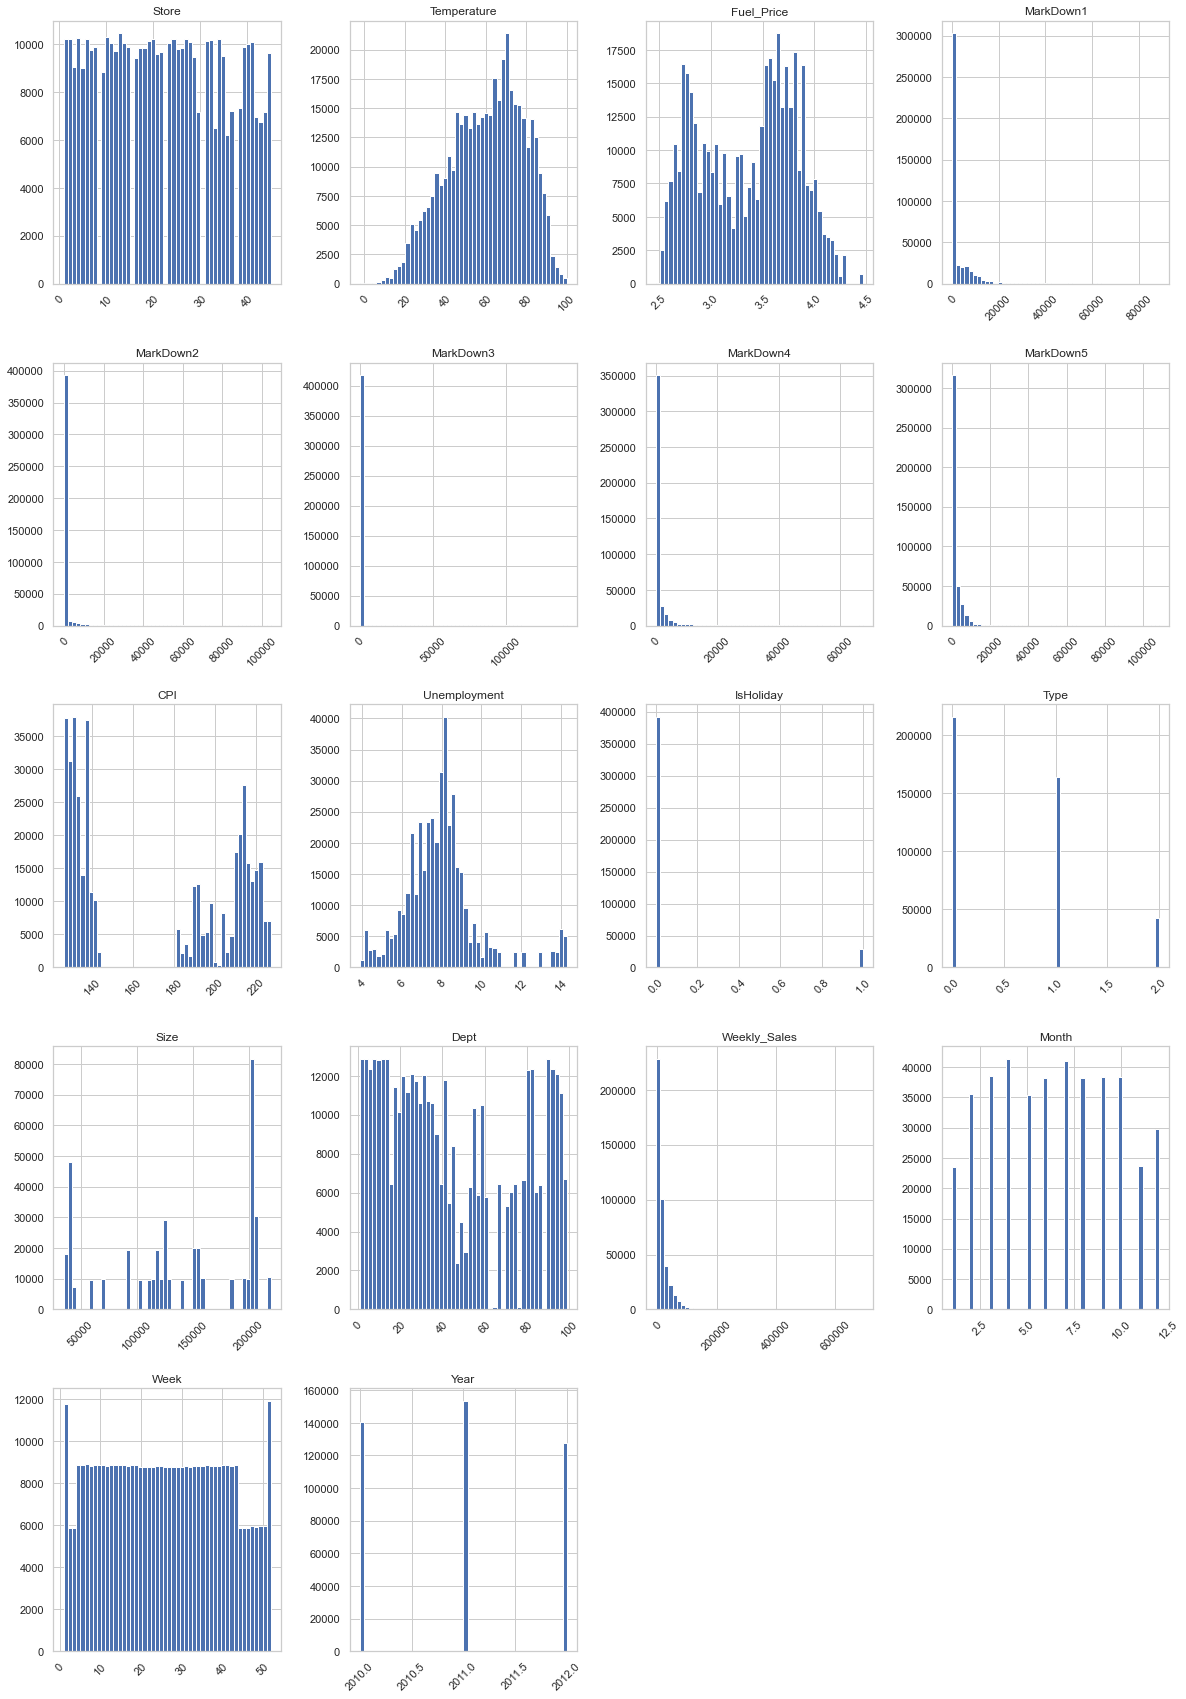

In [ ]:
# plot a histogram to check frequency distribution

df_total.hist(figsize=(20,30), xrot=45, bins=50)
plt.show()

# Temperature is left-skewed (negative skewness)
# MarkDown1-5 heavily imbalanced - perform imputation and apply logarithmic transformation in 2nd iteration (if there is time)
# po

In [ ]:
# plot histogram with plotly
#x1 = df_total["Store"]
#x2 = df_total["Temperature"]
#x3 = df_total["Fuel_Price"]

#x4 = df_total["MarkDown1"]
#x5 = df_total["MarkDown2"]
#x6 = df_total["MarkDown3"]
#x7 = df_total["MarkDown4"]
#x8 = df_total["MarkDown5"]

#x9 = df_total["CPI"]
#x10 = df_total["Unemployment"]
#x11 = df_total["IsHoliday"]
#x12 = df_total["Type"]
#x13 = df_total["Size"]
# x14 = df_total["Dept"]

# x15 = df_total["Weekly_Sales"]
# x16 = df_total["Month"]
# x17 = df_total["Week"]
# x18 = df_total["Year"]

# hist_data = [x1, x2, x3,x4, x5, x6, x7, x8, x9,x10, x11, x12,x13, x14, x15,x16, x17, x18]

# group_labels = ['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', 'Month', 'Week',
       'Year']

# colors = ['#333F44', '#37AA9C', '#94F3E4', '#660000','#663300','#666600','#333300','#000000','#FF0000','#800000','#FFFF00',
          '#808000','#00FF00', '#00FFFF','#008080','#0000FF', '#000080', '#FF00FF']


# Create distplot with curve_type set to 'normal'
#fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
#fig.update_layout(title_text='Curve and Rug Plot')
fig.show()

KeyboardInterrupt: 

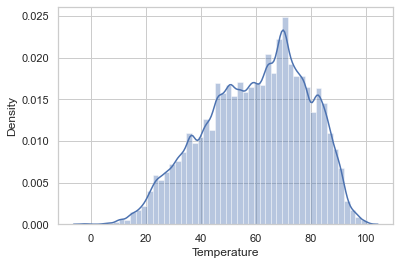

In [ ]:
sns.distplot(df_total["Temperature"])
plt.show()

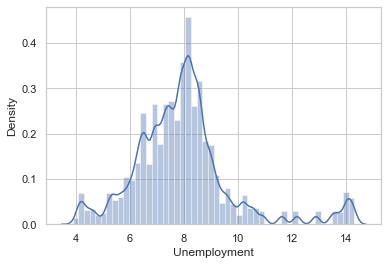

In [ ]:
sns.distplot(df_total["Unemployment"])
plt.show()

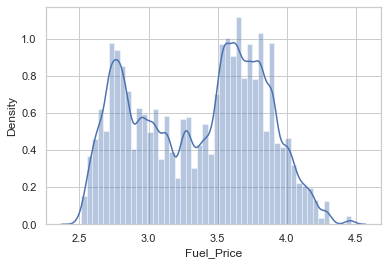

In [ ]:
sns.distplot(df_total["Fuel_Price"])
plt.show()

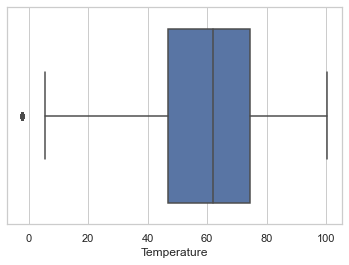

In [ ]:
sns.boxplot(x=df_total["Temperature"])
plt.show()

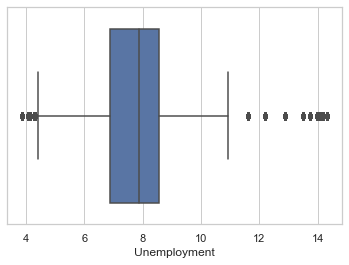

In [ ]:
sns.boxplot(x=df_total["Unemployment"])
plt.show()

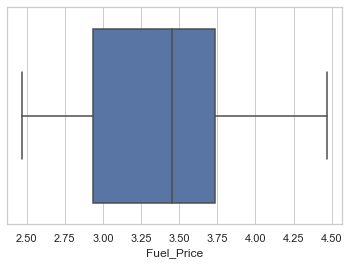

In [ ]:
sns.boxplot(x=df_total["Fuel_Price"])
plt.show()

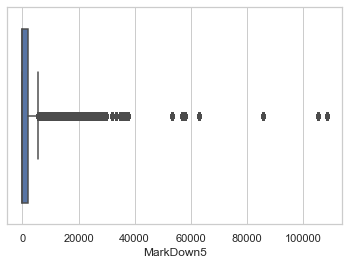

In [ ]:
sns.boxplot(x=df_total["MarkDown5"])
plt.show()